# SPEECH EMOTIONS RECOGNITION PROJECT

## Overview

In Data Science, projects involving emotions detection from facial expression are really popular. Also are common projects that intend to detect emotions from text or from speechs but using the conversion from audio to text as aproach.

In this work I try to use some concepts of Audio Analysis and predict emotions from features derived directly from audio files.

In [97]:
#basic libs
import numpy as np
import os, glob
import sys

#audio libs
import librosa
from librosa import display
import pyaudio

#machine learning libs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

#metrics libs
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ClassPredictionError
from yellowbrick.model_selection import LearningCurve

#plotting libs
import matplotlib.pyplot as plt

#support
from IPython.display import Audio
np.set_printoptions(threshold = sys.maxsize)

%matplotlib inline

**Convention of audio dataset naming**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
* Vocal channel (01 = speech, 02 = song)
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion
* Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”)
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female

In [98]:
#All emotions records avaliable
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
target_emotions = ['calm', 'happy', 'fearful', 'sad', 'angry', 'neutral', 'disgust', 'surprised']

### **1. Inspecting the audio features**

Taking a look at a sample of a file of the dataset. The method librosa.load() returns a list of amplitudes and the sample rate of the audio file.

In [99]:
sample_audio = './audio_speech/Actor_01/03-01-01-01-01-01-01.wav'

y_sample, sr_sample = librosa.load(sample_audio)

In [100]:
print(f"Sample rate: {sr_sample}")

Sample rate: 22050


In [101]:
Audio(data=y_sample, rate=sr_sample)

* **Inspecting Waveform**

Text(0.5, 0, 'Time (s)')

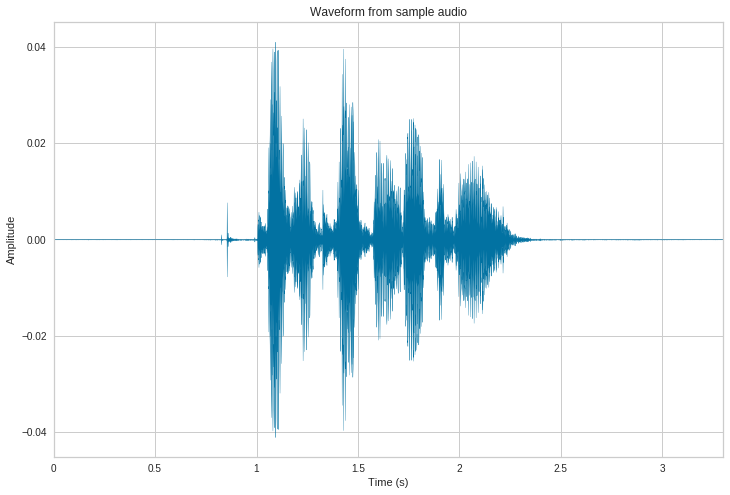

In [102]:
plt.figure(figsize=(12,8))
librosa.display.waveplot(y_sample, sr_sample)
plt.title("Waveform from sample audio")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

* **Inspecting Chromagram**

The audio can have its spectrum represented as the 12 semitones of the musical octave.

/home/czrpxr/py_36_env/lib/python3.6/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


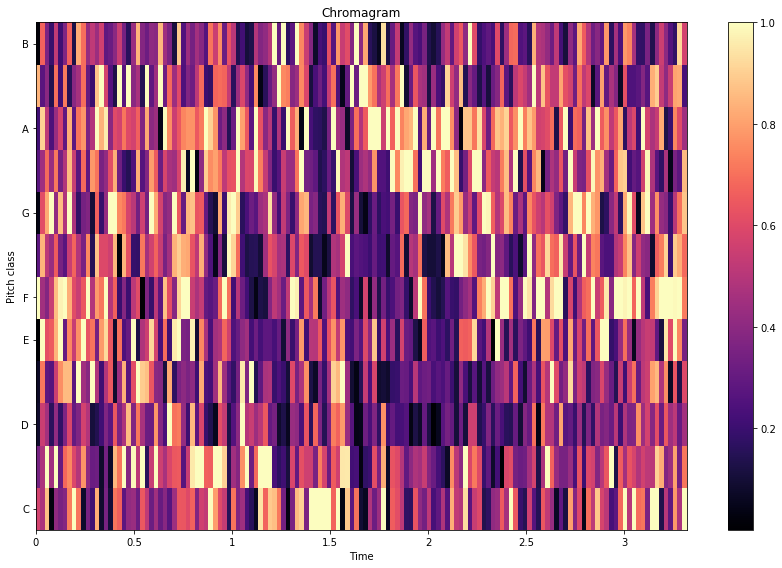

In [7]:
chroma = librosa.feature.chroma_stft(S=librosa.stft(y_sample), sr=sr_sample)

plt.figure(figsize=(12,8))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()

* **Inspecting Mel Spectogram**

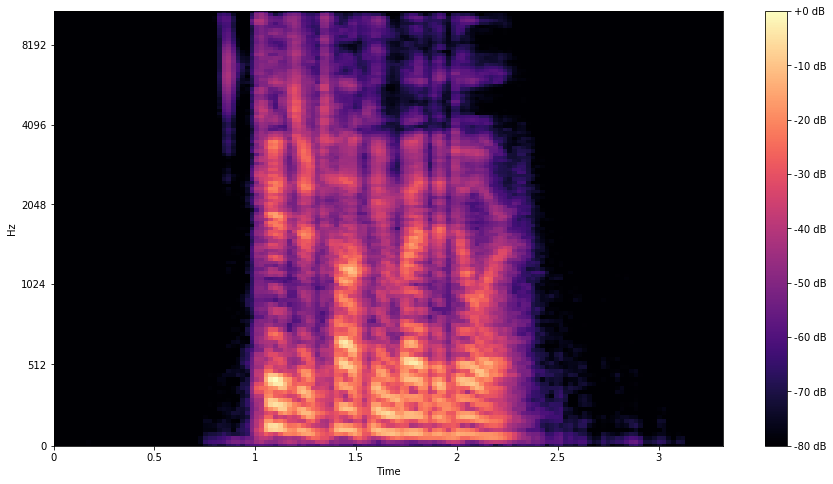

In [8]:
S = librosa.feature.melspectrogram(y_sample, sr=sr_sample)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(15,8))
librosa.display.specshow(S_DB, sr=sr_sample, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

* **Inspecting MFCC**

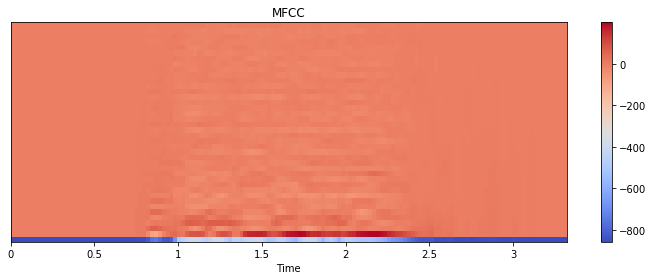

In [9]:
mfccs = librosa.feature.mfcc(y=y_sample, sr=sr_sample, n_mfcc=40, dct_type=2)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.savefig("mfcc.png")

### **2. Defining functions to extract features and create the dataset**

In [10]:
#actual folder = audio_speech
def create_dataset(folder, target_emotions):
    """
    This functions lists all audio files in a folder and pass them to extract_features function
    according to the emotions selected and retrieve variables to be analyzed.
    input:
        folder - Folder where the audio files are stored
        target_emotions - emotions to be searched on the files names
    output:
        An dictionary with target and data.
    """ 
    
    target, data = [], []
    
    for file in glob.glob(f"./{folder}/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        
        if emotion not in target_emotions:
            continue
            
        feature = extract_features(file)
        target.append(emotion)
        data.append(feature)

    return {"target": target, "data": data}

In [11]:
def extract_features(file_name = "", audio_data = 0):
    """
    Open an audio file and extract MFCC, CHROMA and MEL features
    input:
        file_name - Name of the audio file to be acessed
    output:
        item_features - A numpy array with all features aggregated
    """
    if file_name != "" :
    
        item_features = np.array([])

        first_wave, sample_rate = librosa.load(file_name, mono=False)
    
        if first_wave.ndim == 2:
            first_wave = librosa.to_mono(first_wave)
    
        wave, _ = librosa.effects.trim(first_wave)

        mfcc = np.mean(librosa.feature.mfcc(y = wave, sr = sample_rate, n_mfcc=40).T, axis = 0)
        chroma = np.mean(librosa.feature.chroma_stft(S = np.abs(librosa.stft(wave)), sr = sample_rate).T,axis = 0)
        mel = np.mean(librosa.feature.melspectrogram(wave, sr = sample_rate).T, axis = 0)
    
        item_features = np.hstack((mfcc, chroma, mel))
    
        return item_features
    
    else:
        
        wave, _ = librosa.effects.trim(audio_data)
        sample_rate = 22050

        mfcc = np.mean(librosa.feature.mfcc(y = wave, sr = sample_rate, n_mfcc=40).T, axis = 0)
        chroma = np.mean(librosa.feature.chroma_stft(S = np.abs(librosa.stft(wave)), sr = sample_rate).T,axis = 0)
        mel = np.mean(librosa.feature.melspectrogram(wave, sr = sample_rate).T, axis = 0)
    
        item_features = np.hstack((mfcc, chroma, mel))
        
        return item_features
        

### 3. Creating the dataset and splitting into train and test

In [12]:
%%time
ds = create_dataset("audio_speech", target_emotions)

CPU times: user 11min 51s, sys: 5min 2s, total: 16min 54s
Wall time: 5min 43s


In [13]:
X_train, X_test, y_train, y_test = train_test_split(ds['data'], ds['target'], test_size = 0.25, random_state=42)

### 4. Running Machine Learning and Neural Network models

* **Instantiating models**

In [14]:
mlpc = MLPClassifier(random_state=42,
                     activation='logistic', 
                     alpha=0.01, 
                     batch_size=256, 
                     epsilon=1e-08, 
                     hidden_layer_sizes=(150,), 
                     learning_rate='constant', 
                     max_iter=1000,
                     solver='adam')

logreg = LogisticRegression(random_state=42,
                            solver='liblinear',
                            max_iter=5000)

random = RandomForestClassifier(random_state=42,
                                n_estimators=100,
                                min_samples_split=3)

knn = KNeighborsClassifier(n_neighbors=5,
                           metric='minkowski',
                           algorithm = 'auto',
                           p = 1)

svc = SVC(random_state=42,
          gamma='auto',
          kernel='poly')

* **Fitting Models**

In [15]:
mlpc.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [16]:
#ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
random.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

In [19]:
svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

### 5. Prediction results, optimization and analysis

In [20]:
y_mlpc = mlpc.predict(X_test)
accuracy_score(y_test,y_mlpc)

0.6115942028985507

In [21]:
y_logreg = logreg.predict(X_test)
accuracy_score(y_test, y_logreg)

0.45217391304347826

In [22]:
y_random = random.predict(X_test)
accuracy_score(y_test,y_random)

0.5507246376811594

In [23]:
y_knn = knn.predict(X_test)
accuracy_score(y_test,y_knn)

0.48985507246376814

In [24]:
y_svc = svc.predict(X_test)
accuracy_score(y_test,y_svc)

0.5768115942028985

* **Optimizing Params**

In [25]:
params_mlpc = {
    'hidden_layer_sizes':[(100,),(150,),(200,)],
    'activation':['identity', 'logistic', 'tanh', 'relu'],
    'solver':['lbfgs', 'sgd', 'adam'],
    'learning_rate':['constant', 'invscaling', 'adaptive']
}

params_random = {
    'n_estimators': [10,50,100,150],
    'min_samples_split': [2,3,4,5,6,7,8,9,10]
}

params_knn = {
    'n_neighbors': list(range(3,11)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1,2]
}

params_svc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [135]:
clf_random = GridSearchCV(random, params_random, n_jobs=-1, cv=3, scoring='accuracy')
clf_knn = GridSearchCV(knn, params_knn, n_jobs=-1, cv=3, scoring='accuracy')
clf_svc = GridSearchCV(svc, params_svc, n_jobs=-1, cv=3, scoring='accuracy')

In [146]:
clf_random.fit(X_train,y_train)
clf_knn.fit(X_train,y_train)
clf_svc.fit(X_train,y_train)
/

/home/czrpxr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/czrpxr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/czrpxr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


()

In [147]:
print(f"Random: {clf_random.best_params_}")
print(f"KNN: {clf_knn.best_params_}")
print(f"SVC: {clf_svc.best_params_}")

Random: {'min_samples_split': 3, 'n_estimators': 100}
KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
SVC: {'gamma': 'auto', 'kernel': 'poly'}


* **Analysing Classification Report of all models**

In [25]:
print(classification_report(y_test,y_mlpc))

              precision    recall  f1-score   support

       angry       0.58      0.74      0.65        46
        calm       0.66      0.80      0.73        41
     disgust       0.61      0.57      0.59        44
     fearful       0.71      0.78      0.74        50
       happy       0.70      0.48      0.57        44
     neutral       0.37      0.30      0.33        23
         sad       0.55      0.59      0.57        46
   surprised       0.60      0.49      0.54        51

    accuracy                           0.61       345
   macro avg       0.60      0.59      0.59       345
weighted avg       0.61      0.61      0.61       345



In [26]:
print(classification_report(y_test,y_random))

              precision    recall  f1-score   support

       angry       0.85      0.61      0.71        46
        calm       0.50      0.95      0.66        41
     disgust       0.46      0.59      0.51        44
     fearful       0.68      0.52      0.59        50
       happy       0.43      0.43      0.43        44
     neutral       0.55      0.26      0.35        23
         sad       0.56      0.33      0.41        46
   surprised       0.54      0.61      0.57        51

    accuracy                           0.55       345
   macro avg       0.57      0.54      0.53       345
weighted avg       0.58      0.55      0.54       345



In [27]:
print(classification_report(y_test,y_logreg))

              precision    recall  f1-score   support

       angry       0.59      0.59      0.59        46
        calm       0.54      0.68      0.60        41
     disgust       0.42      0.39      0.40        44
     fearful       0.49      0.42      0.45        50
       happy       0.43      0.45      0.44        44
     neutral       0.18      0.13      0.15        23
         sad       0.38      0.39      0.38        46
   surprised       0.42      0.43      0.43        51

    accuracy                           0.45       345
   macro avg       0.43      0.44      0.43       345
weighted avg       0.45      0.45      0.45       345



In [28]:
print(classification_report(y_test,y_knn))

              precision    recall  f1-score   support

       angry       0.50      0.67      0.57        46
        calm       0.50      0.80      0.62        41
     disgust       0.44      0.41      0.42        44
     fearful       0.60      0.52      0.56        50
       happy       0.39      0.32      0.35        44
     neutral       0.29      0.26      0.27        23
         sad       0.52      0.35      0.42        46
   surprised       0.56      0.49      0.52        51

    accuracy                           0.49       345
   macro avg       0.47      0.48      0.47       345
weighted avg       0.49      0.49      0.48       345



In [29]:
print(classification_report(y_test,y_svc))

              precision    recall  f1-score   support

       angry       0.59      0.74      0.65        46
        calm       0.60      0.76      0.67        41
     disgust       0.54      0.57      0.56        44
     fearful       0.61      0.60      0.61        50
       happy       0.62      0.59      0.60        44
     neutral       0.41      0.39      0.40        23
         sad       0.57      0.46      0.51        46
   surprised       0.59      0.45      0.51        51

    accuracy                           0.58       345
   macro avg       0.57      0.57      0.56       345
weighted avg       0.58      0.58      0.57       345



Considering MLPC the best model in the moment, let's take a look at the features behavior at the prediction

### 6. Analyzing MLPC Model Results

* **Classification Report**

/home/czrpxr/py_36_env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/czrpxr/py_36_env/lib/python3.6/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


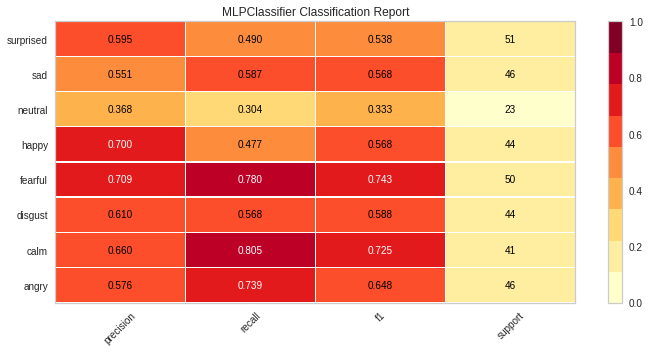

<Figure size 432x288 with 0 Axes>

In [76]:
plt.figure(figsize=(10,5))
class_report = ClassificationReport(mlpc, classes=mlpc.classes_, support=True, is_fitted=True)
class_report.score(X_test, y_test)
class_report.show()
plt.savefig("class_repo.png")

* **Confusion Matrix**

/home/czrpxr/py_36_env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/czrpxr/py_36_env/lib/python3.6/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.6115942028985507

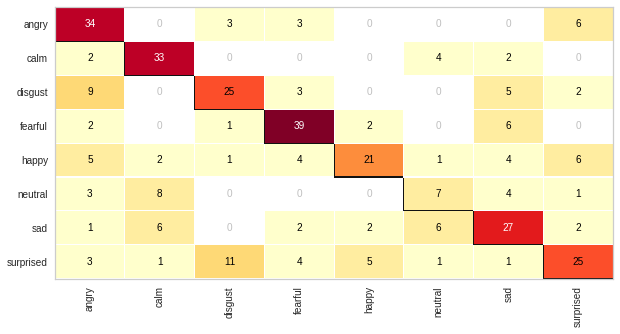

In [77]:
plt.figure(figsize=(10,5))
conf_matrix = ConfusionMatrix(mlpc, classes=mlpc.classes_, label_encoder=emotions, is_fitted=True)
#conf_matrix.fit(X_train, y_train)
conf_matrix.score(X_test, y_test)

### **7. Predicting External Audio**

In [95]:
%matplotlib tk
import time

CHUNK = 1024 #data processed in a cicle
CHANNELS = 1 #audio channels
RATE = 22050 #sample rate
FORMAT = pyaudio.paFloat32


p = pyaudio.PyAudio()


stream = p.open(format = FORMAT,
                channels = CHANNELS,
                rate = RATE,
                input=True,
                output=False,
                frames_per_buffer = CHUNK)

fig, (ax1, ax2)= plt.subplots(2,1, figsize=(12,8))
x = np.arange(0, CHUNK * 2, 2)
line, = ax1.plot(x, np.random.rand(CHUNK))
ax1.set_ylim([-1,1])
proba, = ax2.plot(mlpc.classes_, np.zeros(8), "o")
ax2.set_ylim([0,1])

stream.start_stream()

while stream.is_active():
    data = stream.read(CHUNK)
    data_float = np.frombuffer(data, dtype=np.float32)
    line.set_ydata(data_float)
    
    data_input = extract_features(audio_data = data_float)
    pred = mlpc.predict_proba(data_input.reshape(1,-1))
    proba.set_ydata(pred)
    

    fig.canvas.draw()
    fig.canvas.flush_events()
    
stream.stop_stream()
stream.close()

p.terminate()


/home/czrpxr/py_36_env/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


TclError: invalid command name "pyimage82"

In [96]:
stream.stop_stream()
stream.close()

p.terminate()

### 8.  Predicting an Audio in Portuguese

In [30]:
y_rafa, _ = librosa.load("./audio_speech/teste.ogg")

/home/czrpxr/py_36_env/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [31]:
mlpc.predict(extract_features(audio_data=y_rafa).reshape(1,-1))

array(['angry'], dtype='<U9')

In [32]:
mlpc.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype='<U9')